In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
import numpy as np
import sklearn.model_selection as le_ms
import sklearn.preprocessing as skpp
import xgboost as xgb

In [2]:
df = pd.read_csv('student-mat.csv')

In [3]:
data = df[["G1", "G2", "G3", "studytime", "failures", "absences", "sex", "internet"]]

In [4]:
data['G3_pass_fail'] = ((data['G3'] >= 10).replace({True: 1, False: 0}))
data['sex'] = ((data['sex'] =="F").replace({True: 1, False: 0}))
data['internet'] = ((data['internet'] =="yes").replace({True: 1, False: 0}))
data

C:\Users\roger\AppData\Local\Temp\ipykernel_15680\30093586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['G3_pass_fail'] = ((data['G3'] >= 10).replace({True: 1, False: 0}))
C:\Users\roger\AppData\Local\Temp\ipykernel_15680\30093586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sex'] = ((data['sex'] =="F").replace({True: 1, False: 0}))
C:\Users\roger\AppData\Local\Temp\ipykernel_15680\30093586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,G1,G2,G3,studytime,failures,absences,sex,internet,G3_pass_fail
0,5,6,6,2,0,6,1,0,0
1,5,5,6,2,0,4,1,1,0
2,7,8,10,2,3,10,1,1,1
3,15,14,15,3,0,2,1,1,1
4,6,10,10,2,0,4,1,0,1
...,...,...,...,...,...,...,...,...,...
390,9,9,9,2,2,11,0,0,0
391,14,16,16,1,0,3,0,1,1
392,10,8,7,1,3,3,0,0,0
393,11,12,10,1,0,0,0,1,1


In [5]:
data = data.drop(columns = ['G3'])

In [6]:
X = data.drop(columns= ['G3_pass_fail']).copy() # make a copy of only the x variables
y = data['G3_pass_fail'] # isolate the outcome (y variable)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345, train_size=0.8, stratify= y)

columns = X_train.columns

In [10]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import hyperopt.hp as hpo 

In [11]:
# set the parameter space and values for the algorithm to search through
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
            'gamma': hp.uniform('gamma', 1,9),
            'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
            'reg_lambda': hp.uniform('reg_lambda', 0,1),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1),
            'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
            'n_estimators': 180,
            'eval_metric': 'auc',
            'random_state': [1234],
            'early_stopping': 15
}

In [12]:
N_SPLITS = 10
kfold = le_ms.StratifiedKFold(n_splits = N_SPLITS)


In [13]:
# Regression
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(#n_estimators =space['n_estimators'],
                                max_depth = int(space['max_depth']), gamma = space['gamma'],
                                reg_alpha = int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                                colsample_bytree = space['colsample_bytree'], n_jobs=-1)


    model.fit(trainX, trainY, verbose=False)

    pred = model.predict(testX)
    AUC = sklm.roc_auc_score(testY, pred)
    
    return {'loss':-AUC, 'status': STATUS_OK, 'model': model}

In [14]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [15]:
max_depth_list = []
auc_list = []
gamma_list = []
reg_alpha_list = []
reg_lambda_list = []
col_sample_by_tree_list = []
min_child_weight_list = []

np.random.seed(1234)
for train_index, test_index in kfold.split(range(len(y_train)), y = y_train):
    # split labels and feature matrix
    trainX = X_train[train_index]
    trainY = y_train[train_index]
    testX = X_train[test_index]
    testY = y_train[test_index]
    rstate = np.random.default_rng(1234) # note that you must set this so that the fmin is reproducible
    # run the algorithm
    scaler = skpp.MinMaxScaler()
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)
    testX = scaler.transform(testX)
    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=rstate)

    print(best) # print the best parameter values
    # extract the best model
    best_loss = trials.best_trial['result']['loss'] 
    print(best_loss)

    auc_list.append(best_loss)
    max_depth_list.append(best['max_depth'])
    gamma_list.append(best['gamma'])
    reg_alpha_list.append(best['reg_alpha'])
    reg_lambda_list.append(best['reg_lambda'])
    col_sample_by_tree_list.append(best['colsample_bytree'])
    min_child_weight_list.append(best['min_child_weight'])

100%|██████████| 100/100 [00:08<00:00, 11.59trial/s, best loss: -0.8090909090909092]
{'colsample_bytree': 0.6164615093918191, 'gamma': 5.59513254074879, 'max_depth': 15.0, 'min_child_weight': 5.0, 'reg_alpha': 48.0, 'reg_lambda': 0.731899879071056}
-0.8090909090909092
100%|██████████| 100/100 [00:08<00:00, 11.29trial/s, best loss: -0.9045454545454545]
{'colsample_bytree': 0.6164615093918191, 'gamma': 5.59513254074879, 'max_depth': 15.0, 'min_child_weight': 5.0, 'reg_alpha': 48.0, 'reg_lambda': 0.731899879071056}
-0.9045454545454545
100%|██████████| 100/100 [00:07<00:00, 12.82trial/s, best loss: -0.8138528138528138]
{'colsample_bytree': 0.6164615093918191, 'gamma': 5.59513254074879, 'max_depth': 15.0, 'min_child_weight': 5.0, 'reg_alpha': 48.0, 'reg_lambda': 0.731899879071056}
-0.8138528138528138
100%|██████████| 100/100 [00:08<00:00, 12.34trial/s, best loss: -0.8831168831168831]
{'colsample_bytree': 0.6164615093918191, 'gamma': 5.59513254074879, 'max_depth': 15.0, 'min_child_weight': 5

In [16]:
auc_list = [ -x for x in auc_list]
print(auc_list)
average_auc = sum(auc_list) / len(auc_list)

[0.8090909090909092, 0.9045454545454545, 0.8138528138528138, 0.8831168831168831, 0.9761904761904762, 0.9307359307359306, 0.9761904761904762, 0.9523809523809523, 0.9761904761904762, 0.9761904761904762]


In [17]:
print(average_auc)

0.9198484848484847


In [18]:
print(max_depth_list)
average_max_depth = sum(max_depth_list) / len(max_depth_list)
print(average_max_depth)

[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 18.0, 15.0, 15.0, 15.0]
15.3


In [19]:
print(gamma_list)
average_gamma = sum(gamma_list) / len(gamma_list)
print(average_gamma)

[5.59513254074879, 5.59513254074879, 5.59513254074879, 5.59513254074879, 5.59513254074879, 5.59513254074879, 3.4994058385230735, 5.59513254074879, 5.59513254074879, 5.59513254074879]
5.38555987052622


In [20]:
print(reg_alpha_list)
average_reg_alpha = sum(reg_alpha_list) / len(reg_alpha_list)
print(average_reg_alpha)

[48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 44.0, 48.0, 48.0, 48.0]
47.6


In [21]:
print(reg_lambda_list)
average_reg_lambda = sum(reg_lambda_list) / len(reg_lambda_list)
print(average_reg_lambda)

[0.731899879071056, 0.731899879071056, 0.731899879071056, 0.731899879071056, 0.731899879071056, 0.731899879071056, 0.9758018075941777, 0.731899879071056, 0.731899879071056, 0.731899879071056]
0.7562900719233683


In [22]:
print(col_sample_by_tree_list)
average_col_sample_by_tree = sum(col_sample_by_tree_list) / len(col_sample_by_tree_list)
print(average_col_sample_by_tree)

[0.6164615093918191, 0.6164615093918191, 0.6164615093918191, 0.6164615093918191, 0.6164615093918191, 0.6164615093918191, 0.6436653360513248, 0.6164615093918191, 0.6164615093918191, 0.6164615093918191]
0.6191818920577695


In [23]:
print(min_child_weight_list)
average_min_child_weight = sum(min_child_weight_list) / len(min_child_weight_list)
print(average_min_child_weight)

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 8.0, 5.0, 5.0, 5.0]
5.3


In [24]:
scaler = skpp.MinMaxScaler()
scaler.fit(trainX)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

c:\Users\roger\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [25]:
model = xgb.XGBClassifier(#n_estimators =space['n_estimators'],
                                max_depth = int(average_max_depth), gamma = average_gamma,
                                reg_alpha = int(average_reg_alpha), min_child_weight=average_min_child_weight, reg_lambda = average_reg_lambda,
                                colsample_bytree = average_col_sample_by_tree, n_jobs=-1)


model.fit(X_train, y_train, verbose=False)

pred = model.predict(X_test)
AUC = sklm.roc_auc_score(y_test, pred)
print(AUC)

0.9332365747460087


Text(0.5, 1.0, 'XGBoost Feature Importance')

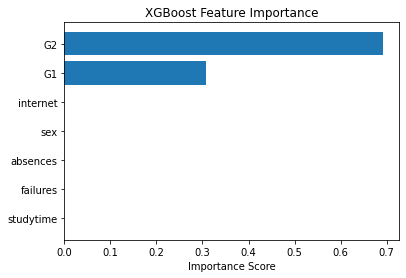

In [26]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance")